Run 1/3
iPSOg is optimizing  "f1"
Run 2/3
iPSOg is optimizing  "f1"
Run 3/3
iPSOg is optimizing  "f1"


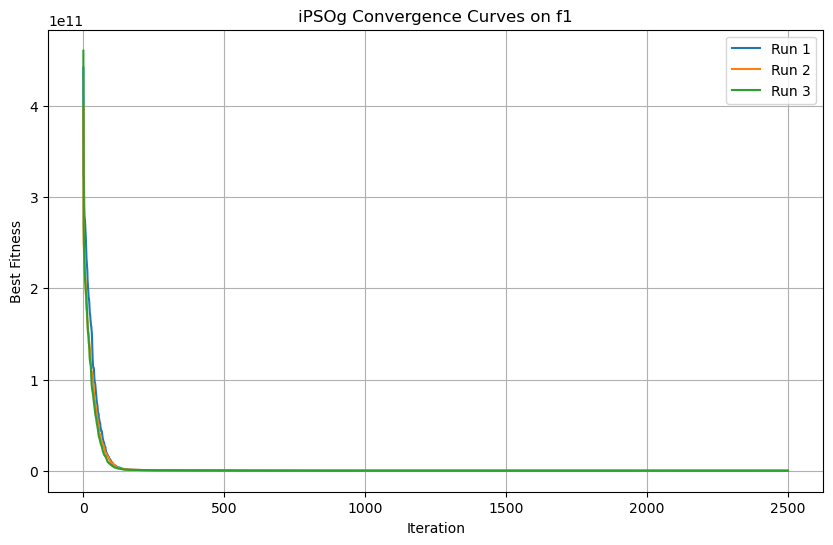

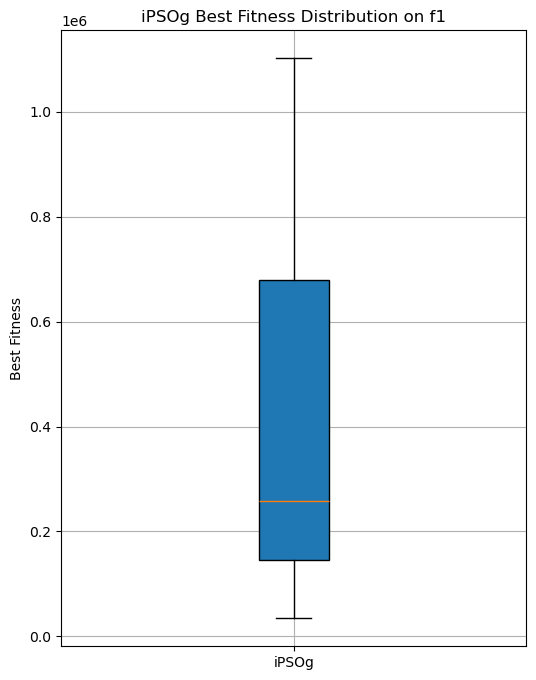

Best fitness values across 3 runs: [34231.17988178578, 1102320.0576372314, 257109.9002970708]
Mean best fitness: 464553.7126053627
Standard deviation of best fitness: 460056.6371980521


In [1]:
import random
import numpy
import math
import time
import opfunu
import pytest
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy
import matplotlib.pyplot as plt

class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

def iPSOg(objf, lb, ub, dim, PopSize, iters, function_name):
    # Algorithm parameters
    Vmax = 6
    wMax = 0.9
    wMin = 0.2
    c1 = 2
    c2 = 2
    
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    # Initialize population
    pos = numpy.zeros((PopSize, dim))
    vel = numpy.zeros((PopSize, dim))
    Cost = numpy.full(PopSize, float("inf"))
    pBestScore = numpy.full(PopSize, float("inf"))
    pBest = numpy.zeros((PopSize, dim))
    gBest = numpy.zeros(dim)
    gBestScore = float("inf")
    uCR = numpy.zeros(PopSize)
    
    # Initialize position and velocity
    for i in range(dim):
        pos[:, i] = numpy.random.uniform(0, 1, PopSize) * (ub[i] - lb[i]) + lb[i]
        vel[:, i] = numpy.random.uniform(-Vmax, Vmax, PopSize)
    
    # Evaluate initial population
    for i in range(PopSize):
        Cost[i] = objf.evaluate(pos[i, :])
        pBestScore[i] = Cost[i]
        pBest[i, :] = pos[i, :].copy()
        
        if Cost[i] < gBestScore:
            gBestScore = Cost[i]
            gBest = pos[i, :].copy()
    
    # Sort initial population
    SmellOrder = numpy.sort(Cost)
    SmellIndex = numpy.argsort(Cost)
    sorted_population = pos[SmellIndex, :]
    Best_X = sorted_population[0, :]
    Best_X2 = sorted_population[1, :]
    Best_X3 = sorted_population[2, :]
    
    convergence_curve = numpy.zeros(iters)
    
    s = solution()
    print('iPSOg is optimizing  "' + function_name + '"')
    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    
    # Main optimization loop
    for l in range(iters):
        # Update ranking-based parameters
        SmellOrder = numpy.sort(Cost)
        SmellIndex = numpy.argsort(Cost)
        
        for i in range(PopSize):
            uCR[SmellIndex[i]] = i / PopSize
        
        # Update inertia weight
        w = wMax - l * ((wMax - wMin) / iters)
        
        for i in range(PopSize):
            # Select two random individuals
            rand = random.sample([x for x in range(PopSize) if x != i], 2)
            r1, r2 = rand[0], rand[1]
            
            # Update velocity and position
            for j in range(dim):
                cof1 = random.random()
                cof2 = random.random()
                
                # Standard PSO velocity update
                vel[i, j] = (w * vel[i, j] + 
                            c1 * cof1 * (pBest[i, j] - pos[i, j]) + 
                            c2 * cof2 * (gBest[j] - pos[i, j]))
                
                # Velocity clamping
                vel[i, j] = numpy.clip(vel[i, j], -Vmax, Vmax)
                
                # Position update
                pos[i, j] = pos[i, j] + vel[i, j]
            
            # Generate a new Solution
            rand = random.sample([x for x in range(PopSize) if x != i], 2)
            r1, r2 = rand[0], rand[1]            
            Xnew = numpy.zeros(dim)
            jrand = numpy.random.randint(0, dim)
            CR = uCR[i] + 0.1 * random.random()
            Xm = (pos[r1, :] + pos[r2, :]) / 2  # Midpoint
            
            for j in range(dim):
                if random.random() < CR or j == jrand:
                    Xnew[j] = Xm[j]
                else:
                    Xnew[j] = pos[i, j]
            
            # Golden Section Search Method 
            r = numpy.random.rand()
            if r < 0.2:
                ids_except_current = [x for x in range(PopSize) if x != i]
                id_1, id_2 = random.sample(ids_except_current, 2)
                
                Xnew1 = gBest + 0.618 * (pos[id_1, :] - pos[id_2, :])
                Xnew2 = pos[i, :] - 0.618 * (pos[id_1, :] - pos[id_2, :])
                alpha = 0.7
                Xnew = alpha * Xnew1 + (1 - alpha) * Xnew2
            
            # Boundary check
            Xnew = numpy.clip(Xnew, lb, ub)
            Xnew_Cost = objf.evaluate(Xnew)
            
            # Update if better solution found
            if Cost[i] > Xnew_Cost:
                Cost[i] = Xnew_Cost
                pos[i, :] = Xnew
                
                if Cost[i] < pBestScore[i]:
                    pBestScore[i] = Cost[i]
                    pBest[i, :] = Xnew.copy()
                
                if Cost[i] < gBestScore:
                    gBestScore = Cost[i]
                    gBest = Xnew.copy()
        
        convergence_curve[l] = gBestScore
    
    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "iPSOg"
    s.objfname = function_name
    s.best = gBestScore
    s.bestIndividual = gBest
    return s

# Parameters
NumOfRuns = 3
dim = 100
PopSize = 30
iters = 2500
lb = -100
ub = 100
function_name = "f1"

if function_name == "f1":
    problem = opfunu.cec_based.F12017(ndim=dim)
elif function_name == "f2":
    problem = opfunu.cec_based.F22017(ndim=dim)
elif function_name == "f3":
    problem = opfunu.cec_based.F32017(ndim=dim)
elif function_name == "f4":
    problem = opfunu.cec_based.F42017(ndim=dim)
elif function_name == "f5":
    problem = opfunu.cec_based.F52017(ndim=dim)
elif function_name == "f6":
    problem = opfunu.cec_based.F62017(ndim=dim)
elif function_name == "f7":
    problem = opfunu.cec_based.F72017(ndim=dim)
elif function_name == "f8":
    problem = opfunu.cec_based.F82017(ndim=dim)
elif function_name == "f9":
    problem = opfunu.cec_based.F92017(ndim=dim)
elif function_name == "f10":
    problem = opfunu.cec_based.F102017(ndim=dim)   
else:
    print("the objective Function is Not belongs to CEC2017")

# Run iPSOg multiple times and collect results
best_fitness_values = []
convergence_curves = []

for run in range(NumOfRuns):
    print(f"Run {run + 1}/{NumOfRuns}")
    s = iPSOg(problem, lb, ub, dim, PopSize, iters, function_name)
    best_fitness_values.append(s.best)
    convergence_curves.append(s.convergence)

# Plot convergence curves
plt.figure(figsize=(10, 6))
for run in range(NumOfRuns):
    plt.plot(convergence_curves[run], label=f'Run {run + 1}')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.title(f'iPSOg Convergence Curves on {function_name}')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Plot box plot
plt.figure(figsize=(6, 8))
plt.boxplot(best_fitness_values, vert=True, patch_artist=True)
plt.ylabel('Best Fitness')
plt.title(f'iPSOg Best Fitness Distribution on {function_name}')
plt.xticks([1], ['iPSOg'])
plt.grid(True)
plt.show()

print(f"Best fitness values across {NumOfRuns} runs: {best_fitness_values}")
print(f"Mean best fitness: {numpy.mean(best_fitness_values)}")
print(f"Standard deviation of best fitness: {numpy.std(best_fitness_values)}")